In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlens.ensemble import SuperLearner

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

[MLENS] backend: threading


In [2]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
def catplot(data, col):
    fig, ax = plt.subplots(1, 3, sharex=True, figsize=(14,4))
    sns.stripplot(data=data, x=col, y='Age', hue='Survived', ax=ax[0])
    sns.countplot(data=data, x=col, hue='Survived', ax=ax[1])
    sns.violinplot(data=data, x=col, y='Age', hue='Survived', ax=ax[2])
    
    print('Name:', col)
    print('Type:', type(col))
    print('% Missing:', data[col].isnull().sum())

Name: Pclass
Type: <class 'str'>
% Missing: 0


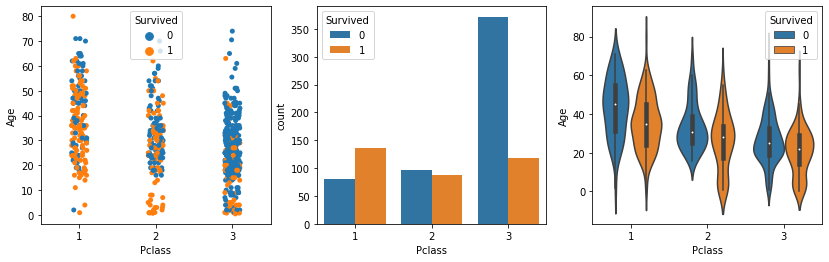

In [9]:
catplot(train, 'Pclass')

Name: Sex
Type: <class 'str'>
% Missing: 0


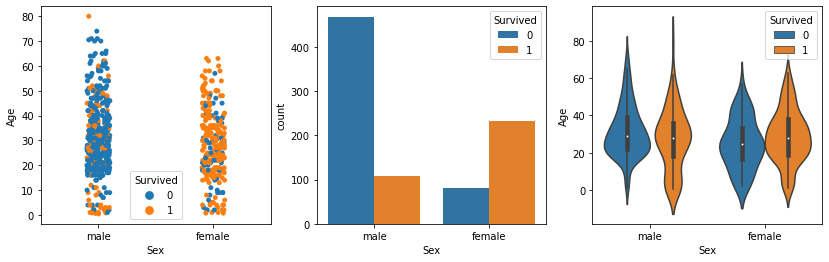

In [10]:
catplot(train, 'Sex')

Name: SibSp
Type: <class 'str'>
% Missing: 0


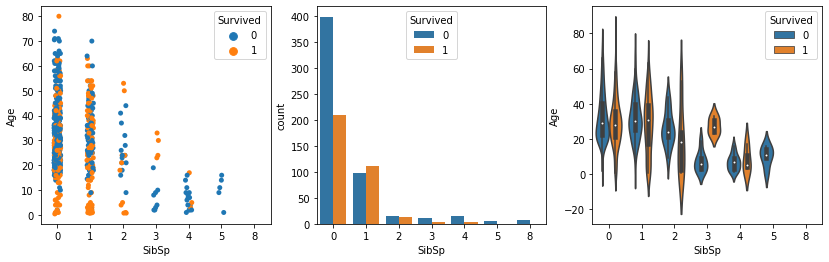

In [11]:
catplot(train, 'SibSp')

Name: Parch
Type: <class 'str'>
% Missing: 0


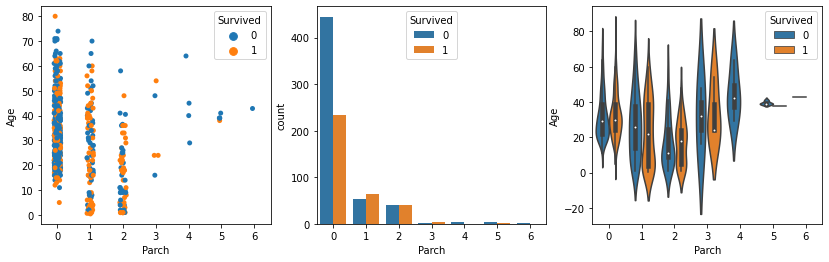

In [12]:
catplot(train, 'Parch')

Name: Embarked
Type: <class 'str'>
% Missing: 2


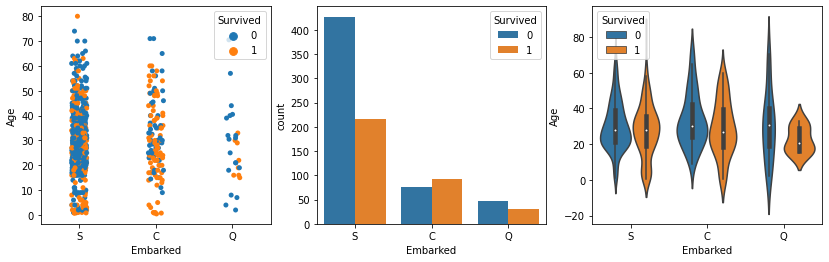

In [13]:
catplot(train, 'Embarked')

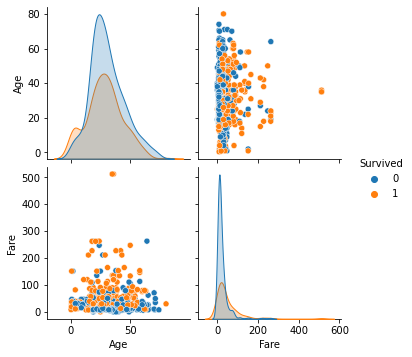

In [14]:
sns.pairplot(train[['Age','Fare','Survived']], hue='Survived')

In [15]:
## Adding more features
df = pd.concat([train, test],sort=False).reset_index(drop=True)

# LastName and Title
df[['LastName', 'Name']] = df['Name'].str.split(', ', expand=True)
df[['Title', 'Name']] = df['Name'].str.split('\. ', expand=True, n=1)

# FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# IsAlone
df['IsAlone'] = np.where(df['FamilySize']==1, 1, 0)

# FamilySurvied, Died
family_sur = []
family_died = []
for idx, row in df.iterrows():
    sur = df[(df['LastName']==row['LastName']) & (df['Survived']==1)]
    died = df[(df['LastName']==row['LastName']) & (df['Survived']==0)]
    
    sur = len(sur)
    died = len(died)
    
    if row['Survived'] == 1:
        sur -= 1
    if row['Survived'] == 0:
        died -= 1
    family_sur.append(sur)
    family_died.append(died)
df['FamilySurvived'] = family_sur
df['FamilyDied'] = family_died

# CabinClass
df['CabinClass'] = [i[0] if pd.notnull(i) else 'X' for i in df['Cabin']]

Name: Title
Type: <class 'str'>
% Missing: 0


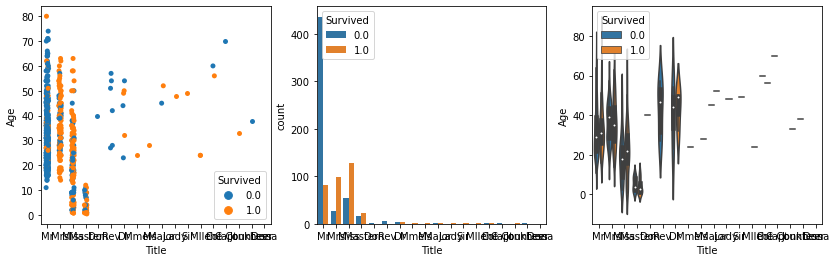

In [16]:
catplot(df, 'Title')

Name: FamilySurvived
Type: <class 'str'>
% Missing: 0


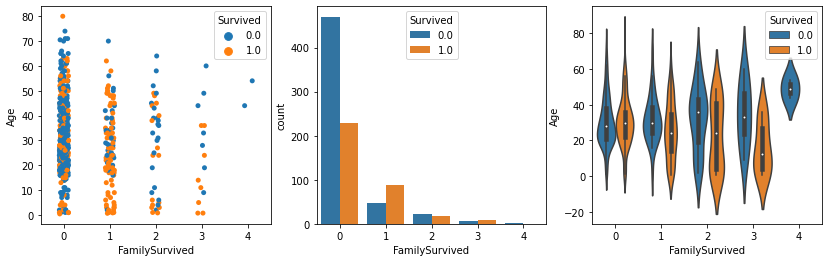

In [17]:
catplot(df, 'FamilySurvived')

Name: FamilyDied
Type: <class 'str'>
% Missing: 0


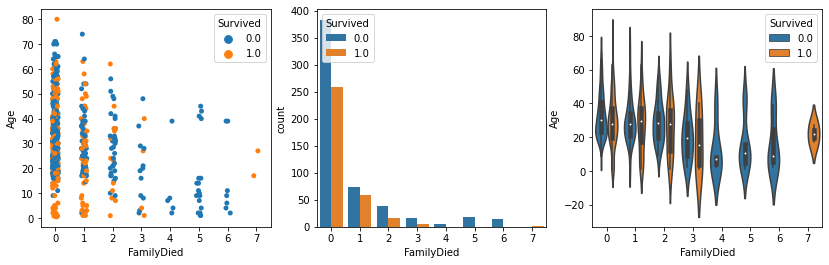

In [18]:
catplot(df, 'FamilyDied')

Name: FamilySize
Type: <class 'str'>
% Missing: 0


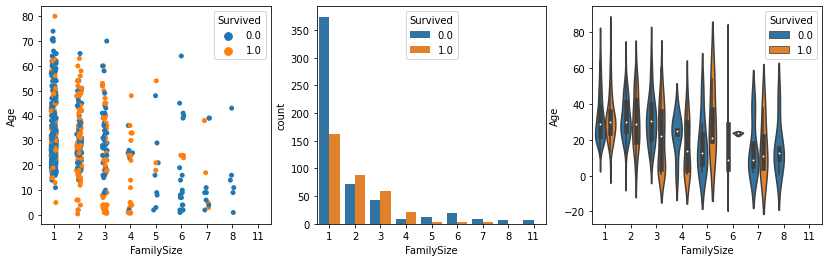

In [19]:
catplot(df, 'FamilySize')

Name: IsAlone
Type: <class 'str'>
% Missing: 0


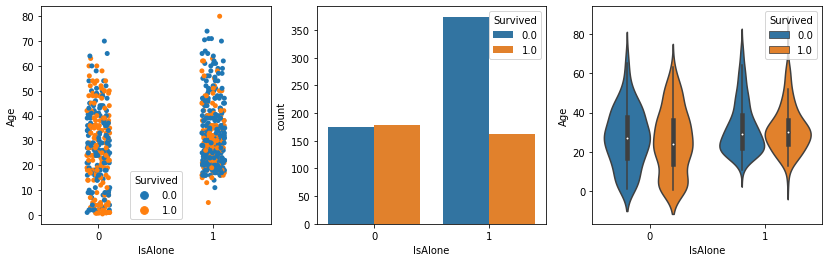

In [20]:
catplot(df, 'IsAlone')

Name: CabinClass
Type: <class 'str'>
% Missing: 0


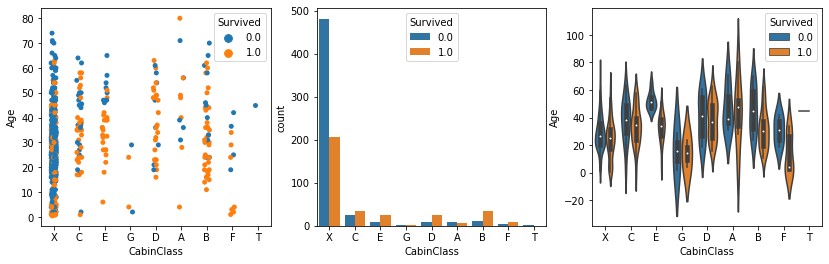

In [21]:
catplot(df, 'CabinClass')

In [22]:
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Lady              1
Mme               1
the Countess      1
Dona              1
Don               1
Jonkheer          1
Capt              1
Sir               1
Name: Title, dtype: int64

In [23]:
# Update Title to common one
title_dict = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Dr':'Dr', 'Rev': 'Rev',
              'Col': 'Mr', 'Ms': 'Miss', 'Mlle': 'Mrs', 'Major': 'Mr', 'Jonkheer': 'Mr', 'the Countess': 'Mrs',
              'Lady': 'Mrs', 'Don': 'Mr', 'Dona': 'Mrs', 'Sir': 'Mr', 'Capt': 'Mr', 'Mme': 'Mrs'}
df['Title'] = df['Title'].map(title_dict)

In [24]:
# Impute
df['Embarked'].fillna(df['Embarked'].mode(), inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

In [25]:
# Label Encoder
lepc = LabelEncoder()
df['Pclass'] = lepc.fit_transform(df['Pclass'].astype(str))

les = LabelEncoder()
df['Sex'] = les.fit_transform(df['Sex'].astype(str))

lee = LabelEncoder()
df['Embarked'] = lee.fit_transform(df['Embarked'].astype(str))

let = LabelEncoder()
df['Title'] = let.fit_transform(df['Title'].astype(str))

lecc = LabelEncoder()
df['CabinClass'] = lecc.fit_transform(df['CabinClass'].astype(str))

In [26]:
# Scaler
sca = StandardScaler()
df['Age'] = sca.fit_transform(df[['Age']].astype(float))

scs = StandardScaler()
df['SibSp'] = scs.fit_transform(df[['SibSp']].astype(float))

scp = StandardScaler()
df['Parch'] = scp.fit_transform(df[['Parch']].astype(float))

scf = StandardScaler()
df['Fare'] = scf.fit_transform(df[['Fare']].astype(float))

scfs = StandardScaler()
df['FamilySize'] = scfs.fit_transform(df[['FamilySize']].astype(float))

scfv = StandardScaler()
df['FamilySurvived'] = scfv.fit_transform(df[['FamilySurvived']].astype(float))

scfd = StandardScaler()
df['FamilyDied'] = scfd.fit_transform(df[['FamilyDied']].astype(float))

In [27]:
# Drop unnecessary columns
df_ready = df.drop(columns=['Name', 'Ticket', 'Cabin', 'LastName']).copy()

Text(0.5, 1.0, 'Correlation')

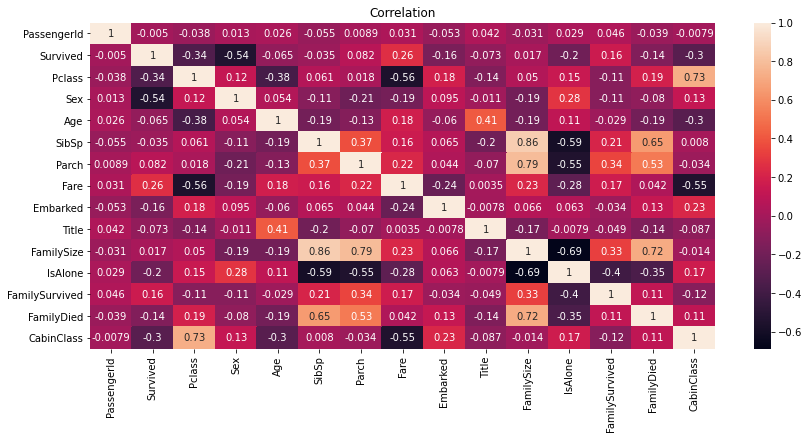

In [28]:
fig = plt.figure(figsize=(14,6))
sns.heatmap(df_ready.corr(), annot=True)
plt.title('Correlation')

In [29]:
# Preapare train and test
train_ready = df_ready[df_ready['Survived'].notnull()]
test_ready = df_ready[df_ready['Survived'].isnull()]

X = train_ready.drop(columns=['PassengerId', 'Survived'])
y = train_ready['Survived']

X_subs = test_ready.drop(columns=['PassengerId', 'Survived'])
id_subs = test_ready['PassengerId']

In [30]:
# Split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=88)

In [31]:
grid_xgb = dict()
grid_xgb['booster'] = ['gbtree', 'gblinear']
grid_xgb['eta'] = [0.1, 0.2, 0.3]

clf_xgb = XGBClassifier(random_state=88)
grid_search = GridSearchCV(estimator = clf_xgb, param_grid = grid_xgb, scoring='accuracy', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

clf_xgb = grid_search.best_estimator_

cv_score = cross_val_score(estimator=clf_xgb, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_xgb.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

[18:47:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'eta': 0.2}
[18:47:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:14] WARNING: C:/Users/Adminis

In [32]:
grid_rf = dict()
grid_rf['criterion'] = ['gini', 'entropy']
grid_rf['max_depth'] = [None, 5, 15, 30]
grid_rf['min_samples_split'] = [2, 5, 10]

clf_rf = RandomForestClassifier(random_state=88)
grid_search = GridSearchCV(estimator = clf_rf, param_grid = grid_rf, scoring='accuracy', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

clf_rf = grid_search.best_estimator_

cv_score = cross_val_score(estimator=clf_rf, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10}
[0.80555556 0.84722222 0.84507042 0.84507042 0.81690141 0.83098592
 0.78873239 0.85915493 0.84507042 0.78873239]
Accuracy: 0.8659217877094972
F1 Score: 0.8181818181818182


In [33]:
grid_lr = dict()
grid_lr['penalty'] = ['l1', 'l2', 'elasticnet', None]
grid_lr['C'] = [1, 5, 30]
grid_lr['solver'] = ['liblinear', 'lbfgs']

clf_lr = LogisticRegression(random_state=88)
grid_search = GridSearchCV(estimator = clf_lr, param_grid = grid_lr, scoring='accuracy', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

clf_lr = grid_search.best_estimator_

cv_score = cross_val_score(estimator=clf_lr, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_lr.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
[0.83333333 0.76388889 0.78873239 0.81690141 0.78873239 0.81690141
 0.83098592 0.8028169  0.85915493 0.73239437]
Accuracy: 0.8435754189944135
F1 Score: 0.787878787878788


In [34]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

cv_score = cross_val_score(estimator=clf_nb, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_nb.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

[0.77777778 0.77777778 0.74647887 0.74647887 0.77464789 0.77464789
 0.81690141 0.8028169  0.84507042 0.74647887]
Accuracy: 0.8044692737430168
F1 Score: 0.7586206896551724


In [35]:
grid_svc = dict()
grid_svc['C'] = [1, 5, 30]
grid_svc['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']

clf_svc = SVC(random_state=88)
grid_search = GridSearchCV(estimator = clf_svc, param_grid = grid_svc, scoring='accuracy', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

clf_svc = grid_search.best_estimator_

cv_score = cross_val_score(estimator=clf_svc, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_svc.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

{'C': 30, 'kernel': 'rbf'}
[0.77777778 0.80555556 0.83098592 0.81690141 0.78873239 0.81690141
 0.83098592 0.85915493 0.85915493 0.78873239]
Accuracy: 0.8715083798882681
F1 Score: 0.8217054263565893


In [36]:
grid_knn = dict()
grid_knn['n_neighbors'] = [3, 5, 10, 15]
grid_knn['weights'] = ['uniform', 'distance']

clf_knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = clf_knn, param_grid = grid_knn, scoring='accuracy', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

clf_knn = grid_search.best_estimator_

cv_score = cross_val_score(estimator=clf_knn, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_knn.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

{'n_neighbors': 15, 'weights': 'distance'}
[0.79166667 0.80555556 0.78873239 0.81690141 0.77464789 0.8028169
 0.71830986 0.78873239 0.81690141 0.74647887]
Accuracy: 0.8547486033519553
F1 Score: 0.8169014084507042


In [37]:
grid_lgbm = dict()
grid_lgbm['boosting_type'] = ['gbdt', 'dart', 'rf', 'goss']

clf_lgbm = LGBMClassifier(random_state=88)
grid_search = GridSearchCV(estimator = clf_lgbm, param_grid = grid_lgbm, scoring='accuracy', cv = 5, n_jobs = -1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

clf_lgbm = grid_search.best_estimator_

cv_score = cross_val_score(estimator=clf_lgbm, X=X_train, y=y_train,scoring='accuracy', cv=10)
print(cv_score)

y_pred = clf_lgbm.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

{'boosting_type': 'goss'}
[0.83333333 0.88888889 0.85915493 0.78873239 0.81690141 0.81690141
 0.78873239 0.83098592 0.83098592 0.78873239]
Accuracy: 0.8770949720670391
F1 Score: 0.8333333333333334


In [38]:
# Super Learner
sl = SuperLearner(folds=5, scorer=accuracy_score)
sl.add([clf_xgb, clf_rf, clf_lr, clf_nb, clf_svc, clf_knn])
sl.add_meta(LogisticRegression())
sl.fit(X_train, y_train)

y_pred = sl.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.8491620111731844
F1 Score: 0.7969924812030075


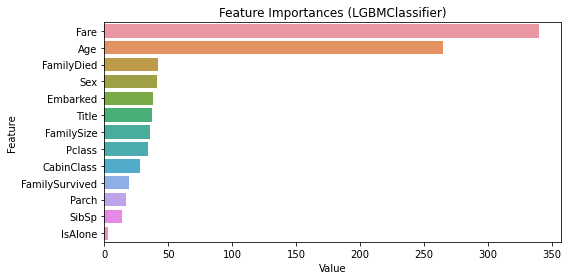

In [54]:
feature_imp = pd.DataFrame(sorted(zip(clf_lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(8, 4))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importances (LGBMClassifier)')
plt.tight_layout()
plt.show()

In [55]:
# Predict
y_subs = clf_lgbm.predict(X_subs)

In [ ]:
submission = pd.DataFrame({'PassengerId': id_subs,
                           'Survived': y_subs.astype(int)})
submission.to_csv('submission.csv', index=False)